In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
from marswinds.utils import radian_to_degree, degree_to_radian
from tensorflow.keras.models import load_model
import joblib
import random
from os import listdir
from os.path import isfile, join

In [2]:
dune_test_path = '../raw_data/images/testing/dunes'
earth_test_path = '../raw_data/images/testing/earth_tests'
no_dune_test_path = '../raw_data/images/testing/no_dunes'
base_folder='../raw_data/trained_models'

regressor = load_model(f'{base_folder}/regressor.h5')
regressor_2 = load_model(f'{base_folder}/final_post_bootcamp.h5')
final_regressor = load_model(f'{base_folder}/final_post_bootcamp.h5')
regressor_dir = load_model(f'{base_folder}/wind_direction.h5')
classifier = load_model(f'{base_folder}/classifier/classifier_210719_Xception.h5')
scaler = joblib.load(f'{base_folder}/scaler.lib')
regressor = load_model(f'{base_folder}/regressor/regressor_210720_tfl_Xception.h5')


/Users/cedric/.pyenv/versions/marswinds/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Testing the regressor

In [3]:
test_files = [f for f in listdir(dune_test_path) if len(f)>30]
test_files

['21.26750068664551_49.7474983215332_021_CW000_-0.46574658155441284_-0.7453307509422302_2.059357166290283.jpg',
 '19.237500762939455_47.067501831054685_01_CW000_-0.20449663698673248_-0.8018671870231628_2.1900315284729004.jpg',
 '19.087500381469727_47.09250183105469_022_CW000_-0.2237136960029602_-0.7975105047225952_2.185014247894287.jpg',
 '20.417499160766603_50.47249908447266_02_CW000_-0.41302981972694397_-0.6695513725280762_1.9943571090698242.jpg',
 '22.292500686645507_50.84750061035156_011_CW000_-0.7236202955245972_-0.5234135985374451_1.9866714477539062.jpg',
 '26.187500762939454_26.297500228881837_023_CW000_-0.8007261753082275_-0.15517187118530273_1.8634003400802612.jpg',
 '19.687500762939454_46.09250183105469_022_CW000_0.01450368296355009_-0.7751427888870239_2.270188093185425.jpg',
 '20.567499923706055_50.897500610351564_023_CW000_-0.4627075791358948_-0.6136460304260254_1.9228026866912842.jpg',
 '21.792500686645507_49.19749984741211_013_CW000_-0.523042619228363_-0.7204879522323608_

In [27]:
def get_label(image_name):
    parts = image_name[:-4].split('_')
    sin = float(parts[-3])
    cos = float(parts[-2])
    angle = radian_to_degree(math.atan2(sin, cos))
    if angle<0: angle+=360
    wind_strength = float(parts[-1])
    
    return(wind_strength, angle)

In [5]:
labels = [get_label(f) for f in test_files]
labels

[(2.059357166290283, 212.000676598226),
 (2.1900315284729004, 194.30692747962922),
 (2.185014247894287, 195.6696073809252),
 (1.9943571090698242, 211.6694179131255),
 (1.9866714477539062, 234.12079457052664),
 (1.8634003400802612, 259.0326533391943),
 (2.270188093185425, 178.9280647700407),
 (1.9228026866912842, 217.01739302513738),
 (2.0700831413269043, 215.97800223638646),
 (1.9671698808670044, 233.44338099528022),
 (1.9932591915130615, 226.50300683897322),
 (2.1576807498931885, 187.1220297670996),
 (2.1004302501678467, 207.56862368589992),
 (1.9003727436065674, 257.3789014103638),
 (1.9484858512878418, 221.82631604218741),
 (1.9881564378738403, 219.07013356872946),
 (2.1548798084259033, 273.9873959783595),
 (2.081341028213501, 226.26078394559008),
 (2.391322374343872, 189.17907164293112),
 (1.8853585720062256, 200.607903101162),
 (2.314349412918091, 187.19673516422816),
 (2.064019203186035, 257.7622584642682),
 (1.761401891708374, 274.10396803443757),
 (1.8781100511550903, 191.89488

In [28]:
def prediction_from_models(image_name, path=False):
        if path:
            image_path = f'{image_name}'
        else:
            image_path = f'{path}/{image_name}'
            
        try:
            image = cv2.imread(image_path)
            #grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
            grey_image = image/255.0
            expanded = np.expand_dims(grey_image,axis=0)
            predicted_regressed = regressor.predict(expanded)[0]
            wind_strength = predicted_regressed[0]
            sin = predicted_regressed[1] 
            cos = predicted_regressed[2]
            angle_rad = math.atan2(sin, cos)
        except Exception as e:
            print(f'Problem with file {image_path}: {e.args}')
            return (0,0)
        
        return (scaler.inverse_transform([[wind_strength]])[0][0], radian_to_degree(angle_rad))

In [19]:
# This cell resets the csv with the results!

from tqdm import tqdm

log_name = '../raw_data/logs/testing_regressor_tfl.csv'

d = {'filename':[],
        'angular_diff':[],
        'speed_diff':[],
    'predicted_angle':[],
    'actual_angle':[],
    'predicted_strength':[],
    'actual_strength':[]}
df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)

In [20]:
def calculate_angular_diff(label_angle, pred_angle):
    if label_angle <0:
        label_angle = 360+label_angle
    if pred_angle <0:
        pred_angle = 360+pred_angle
    
    angle_diff = np.abs(label_angle-pred_angle)
    if angle_diff > 180: angle_diff = 360-angle_diff
        
    return angle_diff
    

def get_diff(files, path=False):
    
    for file in tqdm(files):
        pred_wind, pred_angle = prediction_from_models(file, path)
        label_wind, label_angle = get_label(file)
        
        if pred_angle <0:
            pred_angle = 360+pred_angle
        
        wind_diff = np.abs(label_wind-pred_wind)
        angle_diff = calculate_angular_diff(label_angle, pred_angle)
            
        d = {'filename':[file],
        'angular_diff':[angle_diff**2],
        'speed_diff':[wind_diff**2],
    'predicted_angle':[pred_angle],
    'actual_angle':[label_angle],
    'predicted_strength':[pred_wind],
    'actual_strength':[label_wind]}

        pd.concat([pd.read_csv(log_name), pd.DataFrame.from_dict(d)]).to_csv(log_name, index=False)
    
    return pd.read_csv(log_name)
        
        

In [72]:
get_diff(test_files)

100%|██████████| 8412/8412 [53:05<00:00,  2.64it/s]    


filename  angular_diff  \
0      21.26750068664551_49.7474983215332_021_CW000_-...     32.730407   
1      19.237500762939455_47.067501831054685_01_CW000...      5.965791   
2      19.087500381469727_47.09250183105469_022_CW000...      5.789919   
3      20.417499160766603_50.47249908447266_02_CW000_...     11.582342   
4      22.292500686645507_50.84750061035156_011_CW000...   1214.220166   
...                                                  ...           ...   
16819  27.972500228881835_24.447499084472657_031_CW00...     17.067120   
16820  25.687500762939454_25.772500228881835_022_CW00...    204.230144   
16821  20.867499160766602_51.022501373291014_020_CW00...      0.070960   
16822  18.937499618530275_46.26749877929687_01_CW000_...     29.375650   
16823  22.042499923706053_50.09750137329102_033_CW000...     60.889133   

       speed_diff  predicted_angle  actual_angle  predicted_strength  \
0        0.059706      -153.720373    212.000677            1.815008   
1        0.091921      -163.250576    194.306927            1.886847   
2        0.096134      -161.924168    195.669607            1.874959   
3        0.033163      -151.733866    211.669418            1.812249   
4        0.022191      -160.724868    234.120795            1.837705   
...           ...              ...           ...                 ...   
16819    0.003043       258.526452    262.657689            1.752922   
16820    0.003804       259.589173    245.298262            1.825344   
16821    0.013150       221.268777    221.535161            1.788388   
16822    0.249150       194.599002    189.179072            1.892173   
16823    0.018357       214.391544    222.194693            1.870238   

       actual_strength  
0             2.059357  
1             2.190032  
2             2.185014  
3             1.994357  
4             1.986671  
...                ...  
16819         1.808089  
16820         1.887020  
16821         1.903061  
16822         2.391322  
16823         2.005724  

[16824 rows x 7 columns]

In [75]:
res = pd.read_csv(log_name)
#res.angular_diff = [calculate_angular_diff(r.actual_angle, r.predicted_angle) for i,r in res.iterrowsows()]
start = int(16824/2)
finish = 16824
res = res.iloc[start:finish,:].copy()
res

filename  angular_diff  \
8412   21.26750068664551_49.7474983215332_021_CW000_-...     32.730407   
8413   19.237500762939455_47.067501831054685_01_CW000...      5.965791   
8414   19.087500381469727_47.09250183105469_022_CW000...      5.789919   
8415   20.417499160766603_50.47249908447266_02_CW000_...     11.582342   
8416   22.292500686645507_50.84750061035156_011_CW000...   1214.220166   
...                                                  ...           ...   
16819  27.972500228881835_24.447499084472657_031_CW00...     17.067120   
16820  25.687500762939454_25.772500228881835_022_CW00...    204.230144   
16821  20.867499160766602_51.022501373291014_020_CW00...      0.070960   
16822  18.937499618530275_46.26749877929687_01_CW000_...     29.375650   
16823  22.042499923706053_50.09750137329102_033_CW000...     60.889133   

       speed_diff  predicted_angle  actual_angle  predicted_strength  \
8412     0.059706       206.279627    212.000677            1.815008   
8413     0.091921       196.749424    194.306927            1.886847   
8414     0.096134       198.075832    195.669607            1.874959   
8415     0.033163       208.266134    211.669418            1.812249   
8416     0.022191       199.275132    234.120795            1.837705   
...           ...              ...           ...                 ...   
16819    0.003043       258.526452    262.657689            1.752922   
16820    0.003804       259.589173    245.298262            1.825344   
16821    0.013150       221.268777    221.535161            1.788388   
16822    0.249150       194.599002    189.179072            1.892173   
16823    0.018357       214.391544    222.194693            1.870238   

       actual_strength  
8412          2.059357  
8413          2.190032  
8414          2.185014  
8415          1.994357  
8416          1.986671  
...                ...  
16819         1.808089  
16820         1.887020  
16821         1.903061  
16822         2.391322  
16823         2.005724  

[8412 rows x 7 columns]

In [76]:
np.sqrt(res.angular_diff.mean())

23.06706402676945

In [77]:
print(f'Relative angular error:{np.sqrt(res.angular_diff.mean())/180*100} %')

Relative angular error:12.815035570427472 %


In [78]:
print(f'Relative wind strength error:{np.sqrt(res.speed_diff.mean())/(res.actual_strength.max()-res.actual_strength.min())*100} %') 

Relative wind strength error:5.433812073997648 %


In [79]:
np.sqrt(res.speed_diff.mean())

0.2631413390496813

In [82]:
bad_res = res[res.angular_diff>45**2]

In [83]:
bad_res.drop_duplicates()

filename  angular_diff  \
8421   22.067499923706055_51.022501373291014_020_CW00...   3776.285101   
8488   17.082499694824218_45.33249969482422_012_CW000...   8785.174494   
8498   33.468499755859376_55.61158294677735_02_CW000_...  15969.475366   
8499   22.217500305175783_49.422499084472655_00_CW000...   9642.544804   
8557   21.81750068664551_51.297498321533205_03_CW000_...   9238.060099   
...                                                  ...           ...   
16652  22.292500686645507_50.897500610351564_013_CW00...   2832.638699   
16734  20.79649963378906_33.98266830444336_030_CW000_...  14995.032499   
16773  20.69250030517578_49.397500610351564_013_CW000...   2780.760712   
16783  21.742500686645506_50.94749908447265_031_CW000...   7122.064820   
16804  -24.712500762939452_14.757500457763673_021_CW0...  17939.649754   

       speed_diff  predicted_angle  actual_angle  predicted_strength  \
8421     0.023272       171.991895    233.443381            1.814619   
8488     0.012149       104.124375    197.853637            1.572339   
8498     0.325034        61.588832    295.218443            1.813386   
8499     0.010000       123.347235    221.543695            1.855973   
8557     0.010270       135.552900    231.667727            1.825234   
...           ...              ...           ...                 ...   
16652    0.030557       180.898255    234.120795            1.811865   
16734    2.511300       135.552900    258.007106            1.825234   
16773    0.134993       258.454633    205.721715            1.760239   
16783    0.026400       145.434386    229.826713            1.784582   
16804    2.438081       306.031327     79.970305            1.748883   

       actual_strength  
8421          1.967170  
8488          1.462114  
8498          1.243269  
8499          1.955972  
8557          1.926576  
...                ...  
16652         1.986671  
16734         3.409942  
16773         2.127652  
16783         1.947064  
16804         3.310319  

[308 rows x 7 columns]

In [84]:
np.sqrt(res.angular_diff.mean())

23.06706402676945

In [85]:
mrse_wind_model = np.sqrt(res.speed_diff.mean())

<AxesSubplot:>

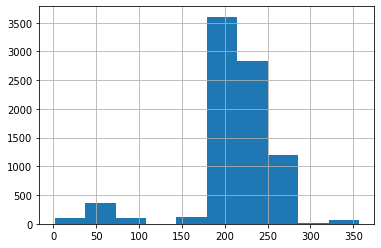

In [86]:
res.actual_angle.hist()

<AxesSubplot:>

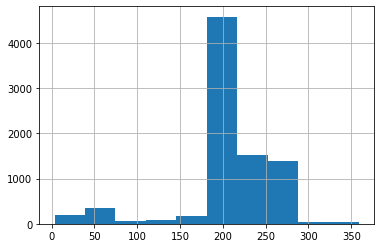

In [87]:
res.predicted_angle.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

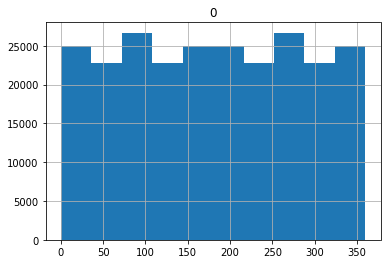

In [88]:
dune_train_path = '../raw_data/images/training/dunes'
train_files = [f for f in listdir(dune_train_path) if len(f)>30]
train_labels_direction = [get_label(f)[1] for f in train_files]
pd.DataFrame(train_labels_direction).hist()

## Getting the 95% CI

In [410]:
error_angle = 1
CI = .95
below_CI = False

while not below_CI:
    above_threshold = res[res.angular_diff >= error_angle**2]
    good_res = 1 - (above_threshold.shape[0]/res.shape[0])
    if good_res <CI:
        error_angle = error_angle+1
    else:
        below_CI = True
        print(good_res)
        
print(f'Error at {CI*100} CI is {error_angle}')


0.9507370543026332
Error at 95.0 CI is 40


In [24]:
def add_arrow(ax, wind_strength, original_angle, color):
    
    arrow_length = int(64 * wind_strength / 2)
    if original_angle < 0: original_angle += 360
    
    if (original_angle<=90):
        arr_angle = degree_to_radian(original_angle)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = op*2
        dy = -adj*2
        tail_x = 128-op
        tail_y = adj+128
    if (original_angle<=180) & (original_angle>90):
        arr_angle = degree_to_radian(original_angle-90)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = adj*2
        dy = op*2
        tail_x = 128-adj
        tail_y = 128-op
    if (original_angle<=270) & (original_angle>180):
        arr_angle = degree_to_radian(original_angle-180)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = -op*2
        dy = adj*2
        tail_x = 128+op
        tail_y = 128-adj
    if (original_angle<=360) & (original_angle>270):
        arr_angle = degree_to_radian(original_angle-270)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = -adj*2
        dy = -op*2
        tail_x = 128+adj
        tail_y = 128+op

    ax.arrow(tail_x,tail_y,dx,dy,color=color,
         length_includes_head=True,
         width=wind_strength*5,
        alpha=.3)
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    
    return ax


def plot_image(folder_name='testing',image_type='dunes', selected_results=None, image_name=None, ax=None, full_path=False):
    
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        
    folder_path = f'../raw_data/images/{folder_name}/{image_type}'
    
    if image_name == None:
        image_name = random.choice(selected_results.filename.values)
    
    if full_path:
        path = image_name
    else:
        path = f'{folder_path}/{image_name}'
        
    data = image_name.split('_')
    wind_strength = float(data[-1].split('.')[0])
    original_sin = float(data[-3])
    original_cos = float(data[-2])
    original_angle = math.atan2(original_sin, original_cos)
    original_angle = radian_to_degree(original_angle)
    
    img = cv2.imread(path)
    ax.imshow(img, cmap='Greys')
    
    add_arrow(ax, wind_strength, original_angle, 'r')
    
    wind_strength, wind_direction =  prediction_from_models(image_name, path=full_path)
    
    add_arrow(ax, wind_strength, wind_direction, 'b')
    
    return ax

def plot_rand_image_grid(grid_dim=5,image_dim=3, selected_results=None, full_path=False, folder_name='testing', image_type='dunes'):
    fig, axes = plt.subplots(grid_dim,grid_dim,figsize=(grid_dim*image_dim,grid_dim*image_dim))
    for ax in axes.flatten():
        plot_image(ax=ax, selected_results=selected_results, full_path = full_path, folder_name=folder_name, image_type=image_type)
    fig.tight_layout()
    return fig

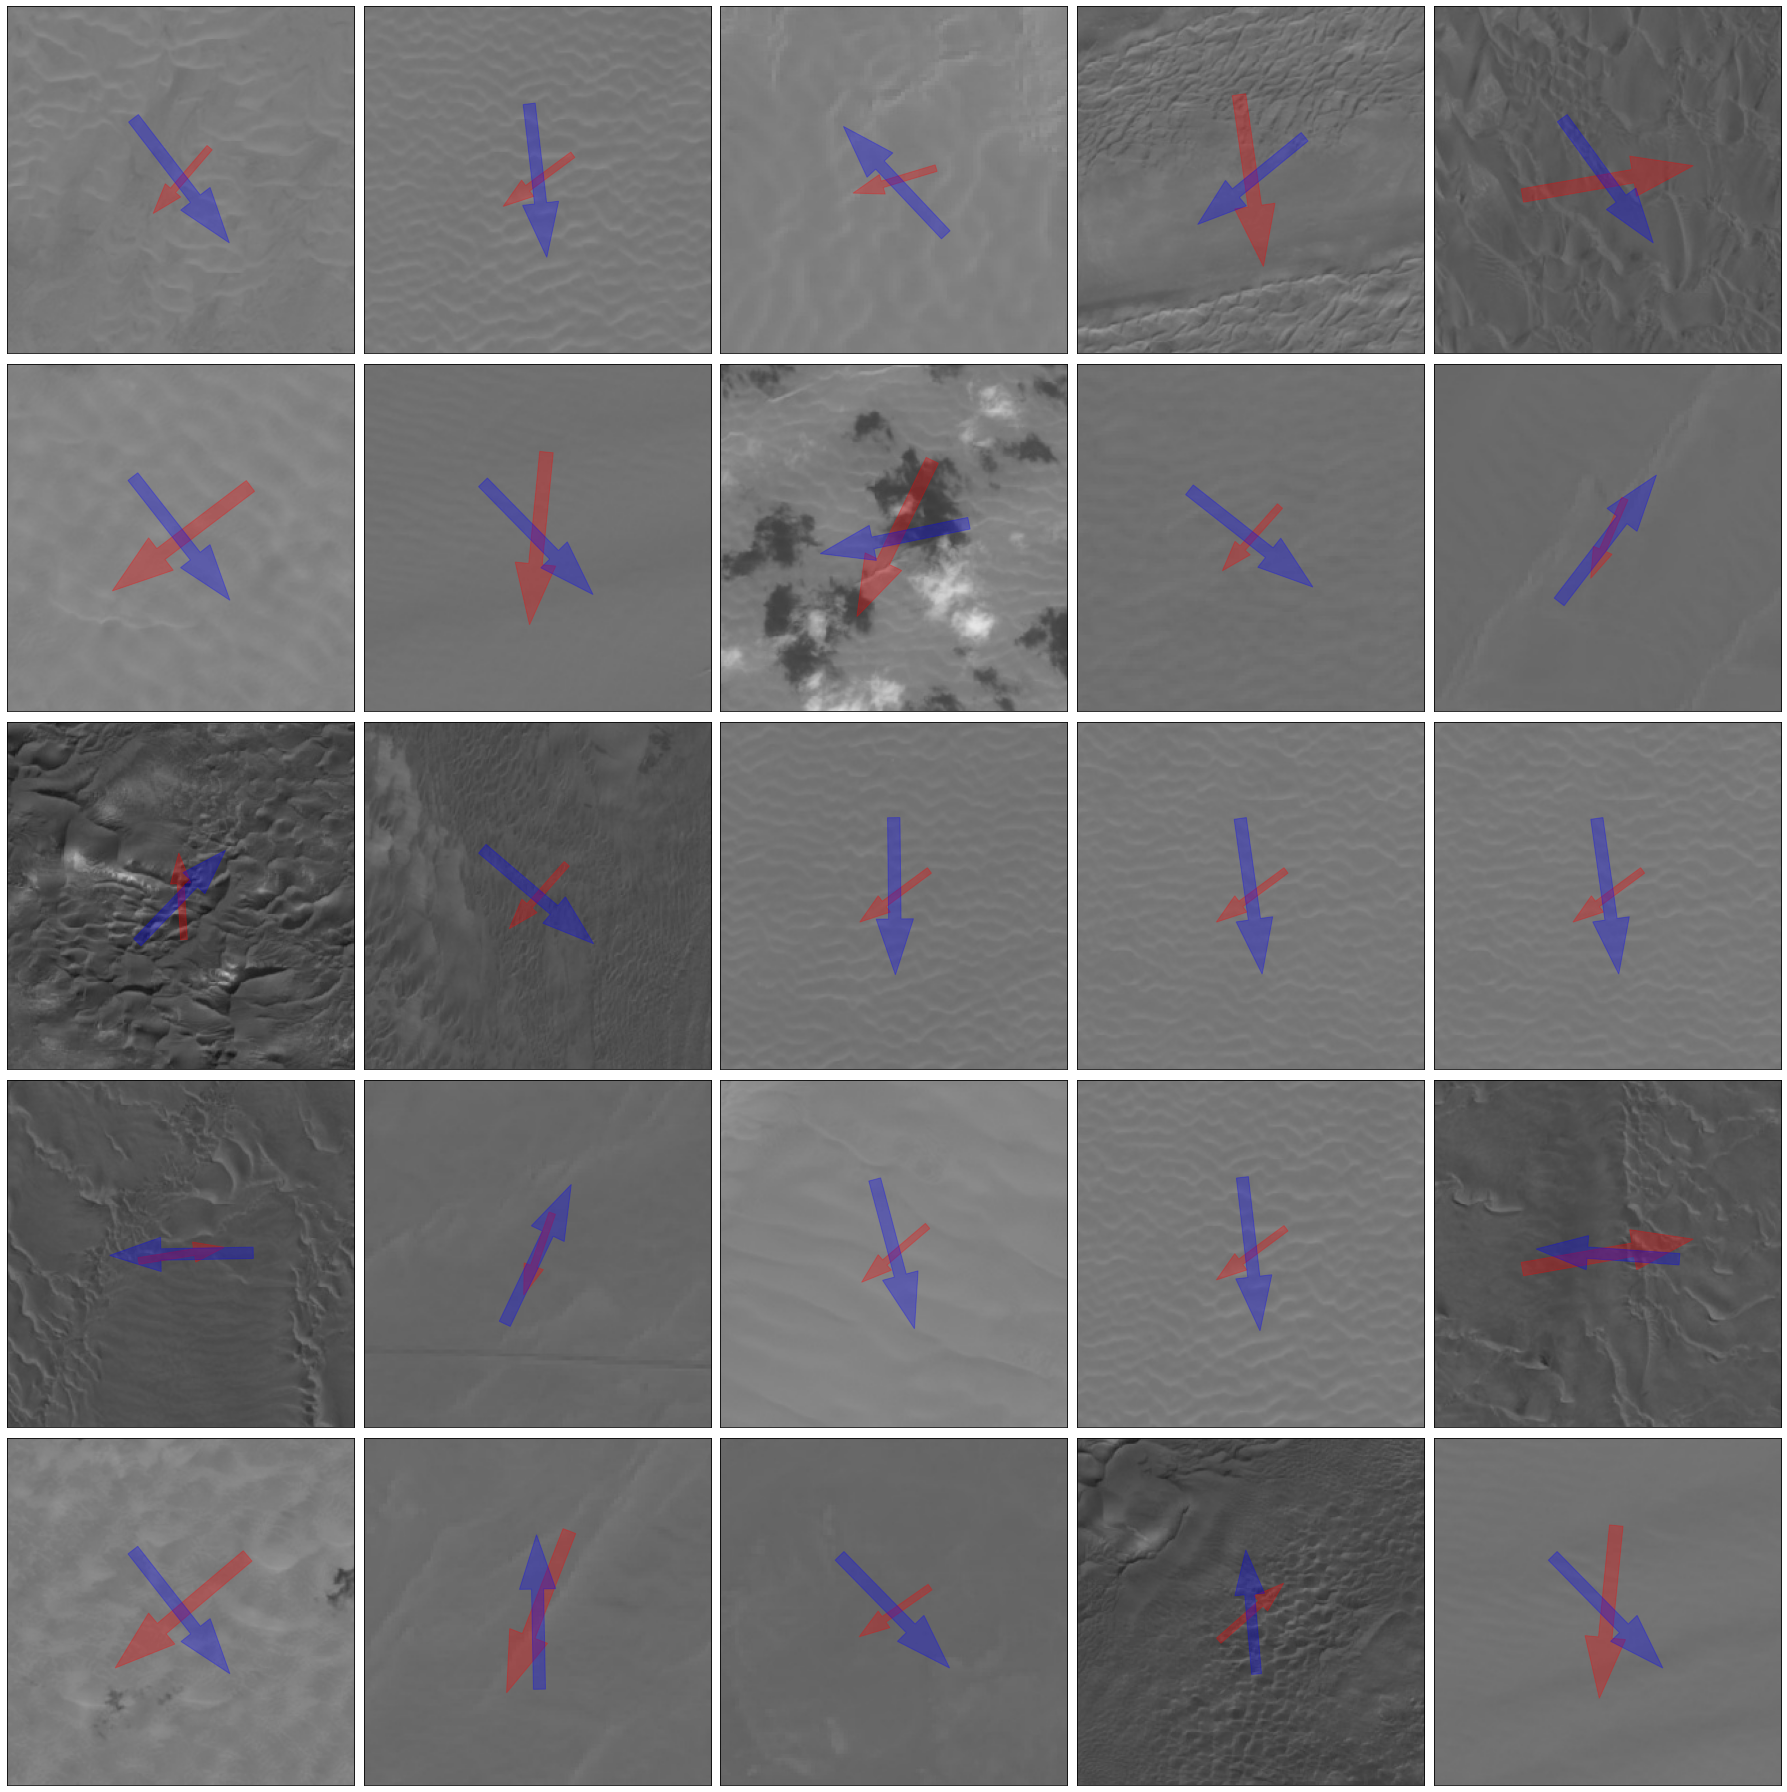

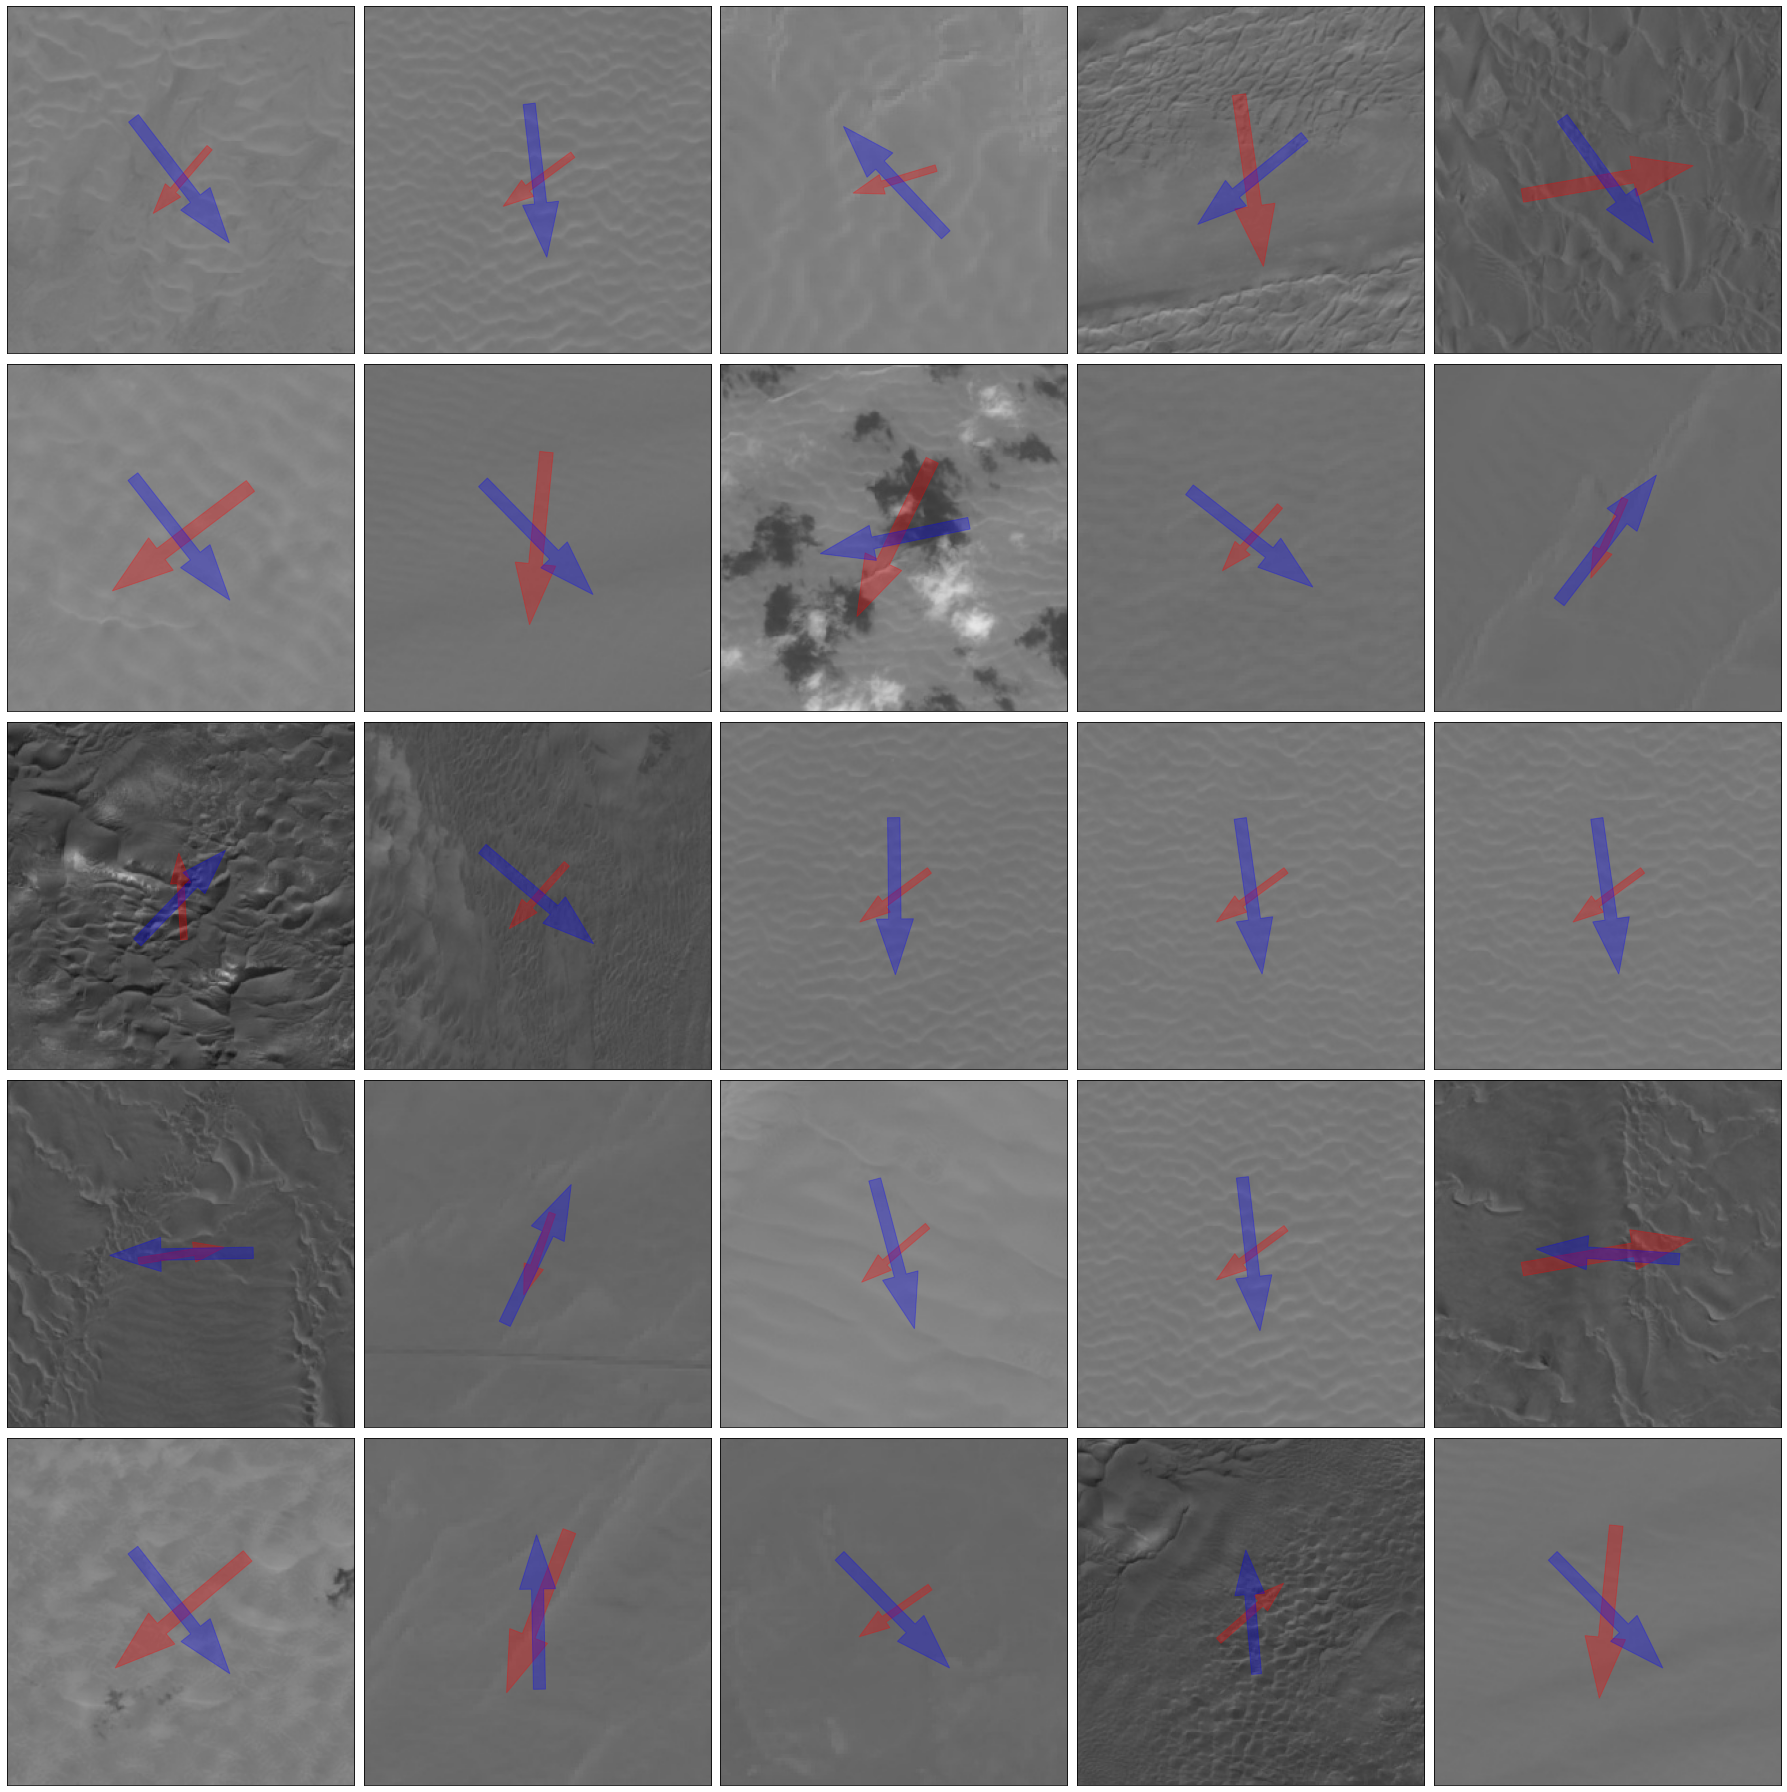

In [137]:
max_error = 45
plot_rand_image_grid(image_dim=5,selected_results = res[res.angular_diff >= max_error**2])

# Testing the Classifier

In [3]:
from tqdm import tqdm

def prediction_from_classifier(image_name, label):
        base_path = '../raw_data/images/testing'
        image_path = f'{base_path}/{label}/{image_name}'
        try:
            image = cv2.imread(image_path)
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
            grey_image = image / 255.0
            expanded = np.expand_dims(np.expand_dims(grey_image,axis=0), axis=3)
            expanded = grey_image
            predicted_proba = classifier.predict(expanded)[0][0]
            if predicted_proba > 0.5:
                predicted_class = 'dunes'
            else:
                predicted_class = 'no_dunes'
        except Exception as e:
            print(f'Problem with file {image_path}: {e.args}')
            return (0,0)
        
        return (predicted_proba, predicted_class)

In [4]:
import tensorflow as tf

def prediction_from_Xception(image):
        try:
            predicted_proba=classifier.predict(image)[0][0]
            if predicted_proba > 0.5:
                predicted_class = 'dunes'
            else:
                predicted_class = 'no_dunes'
        except Exception as e:
            print(f'Problem with file: {e.args}')
            return (0,0)
        
        return (predicted_proba, predicted_class)

#label =  'dunes'
#image_name = '-24.4625_14.732500457763672_00_CW000_0.8945146799087524_0.16531114280223846_2.8569908142089844.jpg'
#label =  'no_dunes'
#image_name = '14.70750026702881_48.08249969482422_022_CW000_0.6427724361419678_-0.22423656284809113_1.2981243133544922.jpg'
#prediction_from_Xception(image_name,'no_dunes')

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

log_name = '../raw_data/logs/testing_earth_classifier.csv'

d = {'image':[],
    'actual_class':[],
    'predicted_class':[],
    'predicted_proba':[]}

df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)

test_dir = '../raw_data/images/testing/'

test_datagen = ImageDataGenerator(rescale=1./255)
    
test_flow = test_datagen.flow_from_directory(test_dir,
                                                    batch_size=1,
                                                     shuffle=True,
                                                   classes = ['earth_tests'],
                                                    class_mode='binary',
                                                    color_mode="grayscale",
                                                    target_size=(256, 256))


Found 581 images belonging to 1 classes.


In [8]:
def convert_label(label):
    if label > 0:
        label = 'dunes'
    else:
        label = 'no_dunes'
    return label

def get_class(flow):
    has_next = True
    
    for i in tqdm(range(flow.n)):
        next_img = flow.next()
        indx = flow.batch_index-1
        file_name_index = flow.index_array[indx]
        path = flow.filepaths[file_name_index]
        label = next_img[1]
        label = convert_label(int(label))
        img = next_img[0]
        pred_proba, pred_class = prediction_from_Xception(img)
        #pred_class = convert_label(int(pred_label))

        d = {'image':[path],
        'actual_class':[label],
        'predicted_class':[pred_class],
        'predicted_proba':[pred_proba]}
        
        #print(f'Predicted: {pred_class} / Actual: {label}')
        pd.concat([pd.read_csv(log_name), pd.DataFrame.from_dict(d)]).to_csv(log_name, index=False)
        
        
        
        

In [9]:
get_class(test_flow)

100%|██████████| 581/581 [00:36<00:00, 15.88it/s]


In [12]:
class_res = pd.read_csv(log_name).copy()
class_res.to_csv('../raw_data/trained_models/classifier/earth_tests_jul21_gcp.csv',index=False)

../raw_data/images/testing/dunes/40.04249877929688_102.07749633789062_011_CW000_0.24153955280780792_0.21609920263290405_1.06755793094635.jpg
(1, 256, 256, 1)
dunes
0.7529412
0.75294125
(0.9993112, 'dunes')
(0.9993112, 'dunes')
(256, 256)


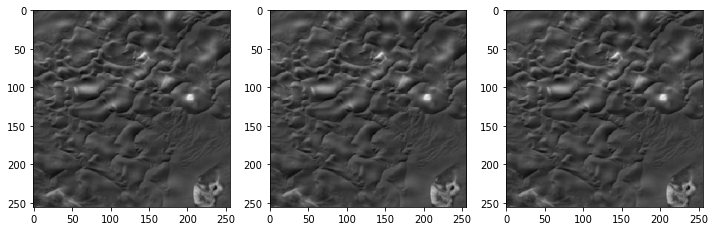

In [508]:
next_img = test_flow.next()
indx = test_flow.batch_index-1
file_name_index = test_flow.index_array[indx]
path = test_flow.filepaths[file_name_index]
#path = test_flow.filepaths[indx]
label = next_img[1]
if label > 0:
    label = 'dunes'
else:
    label = 'no_dunes'
img = next_img[0]
print(path)
print(img.shape)
print(label)
fix, ax = plt.subplots(1,3, figsize=(12,6))
cv_im = (cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255.).astype('float32')
ax[0].imshow(img[0], cmap='gray');
ax[1].imshow(cv_im,cmap='gray');
ax[2].imshow(cv2.imread(path, cv2.IMREAD_GRAYSCALE),cmap='gray')
#ax[2].imshow(cv_im-img[0],cmap='gray');
print(cv_im.max());
print(img[0].max());
print(prediction_from_Xception(img))
exp_image = np.expand_dims(np.expand_dims(cv_im,axis=0), axis=3)
print(prediction_from_Xception(exp_image))
print(cv2.imread(path, cv2.IMREAD_GRAYSCALE).shape)

In [530]:
reg_data_gen = ImageDataGenerator(rescale=1./255)
reg_flow = reg_data_gen.flow_from_directory(directory=test_dir,
                                                            batch_size=1,
                                                            class_mode= 'categorical',
                                                            save_format='png',
                                                            color_mode="rgb",
                                                            target_size=(256, 256))

Found 16824 images belonging to 2 classes.


../raw_data/images/testing/no_dunes/31.778500747680663_57.45603485107422_012_CW000_-0.8882879018783569_0.3220795691013336_1.975223422050476.jpg
(1, 256, 256, 3)
[[1. 0.]]
[0.4]
[0.32156864 0.32156864 0.32156864]


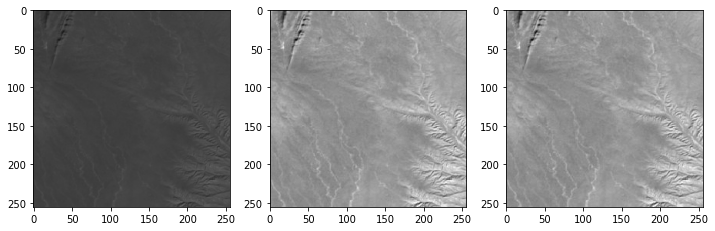

In [578]:
next_img = reg_flow.next()
indx = reg_flow.batch_index-1
file_name_index = reg_flow.index_array[indx]
path = reg_flow.filepaths[file_name_index]
#path = test_flow.filepaths[indx]
img = next_img[0]
print(path)
print(img.shape)
print(label)
fix, ax = plt.subplots(1,3, figsize=(12,6))
base_im = (cv2.imread(path,cv2.IMREAD_GRAYSCALE)/255.).astype('float32')
ax[0].imshow(img[0], cmap='gray');
ax[1].imshow(img[0][:,:,0], cmap='gray');
ax[2].imshow(cv2.imread(path, cv2.IMREAD_GRAYSCALE),cmap='gray');
print(cv_im[0][0])
print(img[0][0][0])

In [585]:
base_im = (cv2.imread('../raw_data/mars_images/alt/Blue-Dunes-on-Mars_r.jpg',cv2.IMREAD_GRAYSCALE)/255.).astype('float32')

In [586]:
base_im.shape

(1028, 1347)

In [13]:
results = class_res.copy().reindex()
results

image actual_class  \
0    ../raw_data/images/testing/earth_tests/-14.202...     no_dunes   
1    ../raw_data/images/testing/earth_tests/-13.952...     no_dunes   
2    ../raw_data/images/testing/earth_tests/-13.702...     no_dunes   
3    ../raw_data/images/testing/earth_tests/-13.902...     no_dunes   
4    ../raw_data/images/testing/earth_tests/-13.727...     no_dunes   
..                                                 ...          ...   
576  ../raw_data/images/testing/earth_tests/-14.052...     no_dunes   
577  ../raw_data/images/testing/earth_tests/-14.252...     no_dunes   
578  ../raw_data/images/testing/earth_tests/-14.127...     no_dunes   
579  ../raw_data/images/testing/earth_tests/-13.902...     no_dunes   
580  ../raw_data/images/testing/earth_tests/-14.252...     no_dunes   

    predicted_class  predicted_proba  
0          no_dunes     1.359016e-02  
1          no_dunes     2.337065e-02  
2          no_dunes     5.709100e-07  
3          no_dunes     2.621444e-02  
4          no_dunes     4.327386e-02  
..              ...              ...  
576        no_dunes     2.894017e-03  
577        no_dunes     1.842626e-01  
578           dunes     9.349385e-01  
579        no_dunes     1.640900e-03  
580        no_dunes     4.766786e-02  

[581 rows x 4 columns]

In [16]:
results.predicted_class.value_counts()

no_dunes    406
dunes       175
Name: predicted_class, dtype: int64

In [31]:
log_name = '../raw_data/trained_models/regressor/earth_tests_jul21_gcp.csv'
get_diff(results.image.values, path=True)

  0%|          | 0/581 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/trained_models/regressor/earth_tests_jul21_gcp.csv'

AttributeError: 'DataFrame' object has no attribute 'filename'

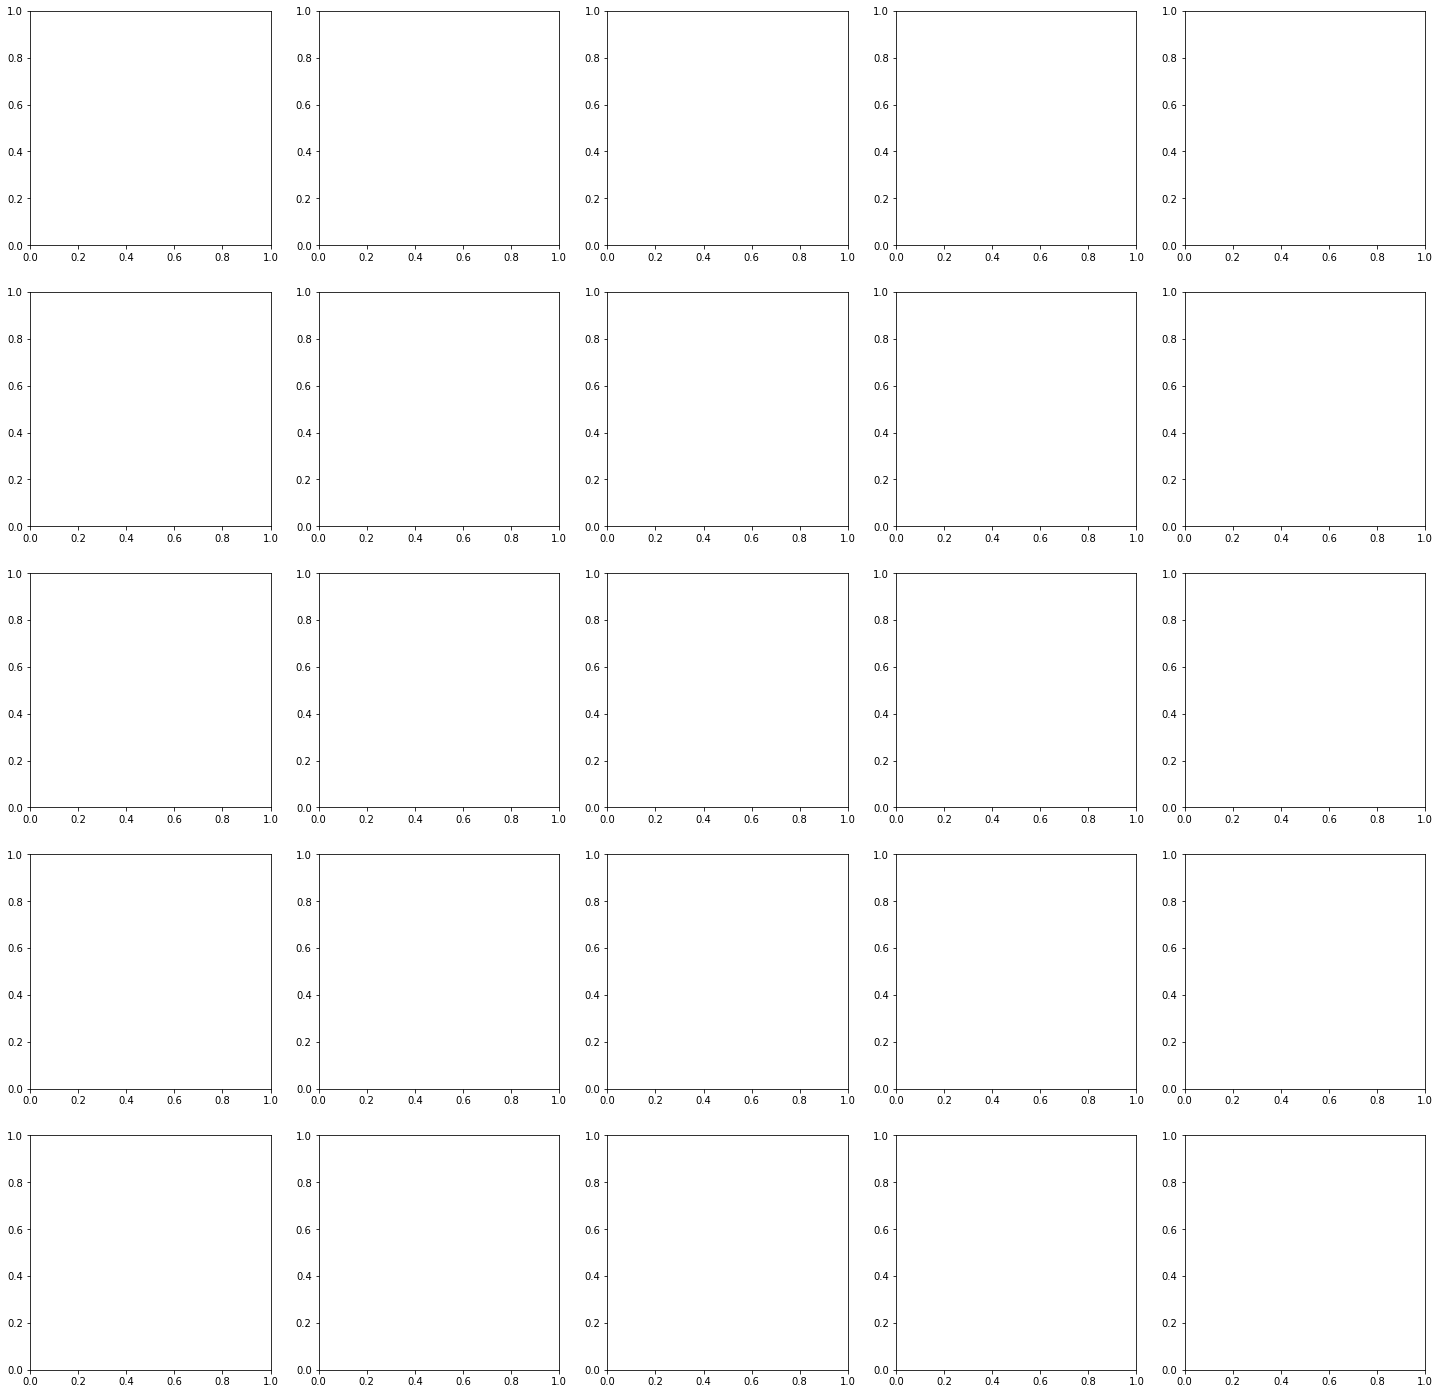

In [25]:
dune_results = results[results.predicted_class=='dunes']
plot_rand_image_grid(image_dim=5,selected_results=dune_results, full_path=True, image_type='earth_tests');

In [342]:
results.reset_index(inplace=True)

In [311]:
bad_res = results[results.predicted_class != results.actual_class]
bad_res

image actual_class  \
1325   ../raw_data/images/testing/no_dunes/19.7925006...     no_dunes   
1339   ../raw_data/images/testing/no_dunes/31.9995010...     no_dunes   
1348   ../raw_data/images/testing/no_dunes/21.6925003...     no_dunes   
1355   ../raw_data/images/testing/no_dunes/28.8055007...     no_dunes   
1356   ../raw_data/images/testing/no_dunes/26.2825004...     no_dunes   
...                                                  ...          ...   
18081  ../raw_data/images/testing/no_dunes/34.0434982...     no_dunes   
18082  ../raw_data/images/testing/no_dunes/33.9434997...     no_dunes   
18092  ../raw_data/images/testing/no_dunes/43.3425003...     no_dunes   
18101  ../raw_data/images/testing/no_dunes/20.6715007...     no_dunes   
18111  ../raw_data/images/testing/no_dunes/44.9195014...     no_dunes   

      predicted_class  predicted_proba  
1325            dunes         0.774162  
1339            dunes         0.640045  
1348            dunes         0.978302  
1355            dunes         0.709226  
1356            dunes         0.738816  
...               ...              ...  
18081           dunes         0.999712  
18082           dunes         0.999119  
18092           dunes         0.701373  
18101           dunes         0.841784  
18111           dunes         0.755937  

[1674 rows x 4 columns]

In [312]:
(results.shape[0]-bad_res.shape[0])/results.shape[0]

0.9004992867332382

In [313]:
bad_res[bad_res.actual_class == 'no_dunes'].shape

(1619, 4)

<AxesSubplot:>

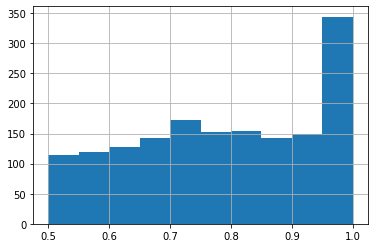

In [314]:
bad_res[bad_res.actual_class == 'no_dunes'].predicted_proba.hist()

<AxesSubplot:>

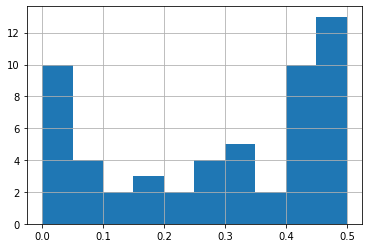

In [315]:
bad_res[bad_res.actual_class == 'dunes'].predicted_proba.hist()

In [354]:
def classification_metrics(results):
    results.dropna(inplace=True)
    TP = results[(results.actual_class == results.predicted_class)&(results.actual_class == 'dunes')]
    TN = results[(results.actual_class == results.predicted_class)&(results.actual_class == 'no_dunes')]
    FP = results[(results.actual_class != results.predicted_class)&(results.predicted_class == 'dunes')]
    FN = results[(results.actual_class != results.predicted_class)&(results.predicted_class == 'no_dunes')]
   
    tp = TP.shape[0]
    tn = TN.shape[0]
    fp = FP.shape[0]
    fn = FN.shape[0]
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    return (precision, recall, accuracy)

def adjust_decision_boundary(initial_df, boundary):
    results = initial_df.copy()
    for index, row in initial_df.iterrows():
        if row.predicted_proba >= boundary:
            row.predicted_class = 'dunes'
        else:
            row.predicted_class = 'no_dunes'
        results.iloc[index] = row.copy()
    return results
            

In [327]:
precision, recall, accuracy = classification_metrics(results)
print(f'Accuracy:{accuracy}')
print(f'Precision:{precision}')
print(f'Recall:{recall}')

Accuracy:0.9004992867332382
Precision:0.83771050521251
Recall:0.9934617213504517


In [352]:
results.drop('index', axis=1, inplace=True)
results

image actual_class  \
0      ../raw_data/images/testing/no_dunes/21.0465003...     no_dunes   
1      ../raw_data/images/testing/dunes/19.2125007629...        dunes   
2      ../raw_data/images/testing/dunes/17.2325004577...        dunes   
3      ../raw_data/images/testing/no_dunes/21.0965007...     no_dunes   
4      ../raw_data/images/testing/dunes/22.0674999237...        dunes   
...                                                  ...          ...   
16819  ../raw_data/images/testing/dunes/21.8424991607...        dunes   
16820  ../raw_data/images/testing/no_dunes/41.0205009...     no_dunes   
16821  ../raw_data/images/testing/dunes/21.9174991607...        dunes   
16822  ../raw_data/images/testing/no_dunes/43.3175003...     no_dunes   
16823  ../raw_data/images/testing/no_dunes/41.6454994...     no_dunes   

      predicted_class  predicted_proba  
0            no_dunes         0.475523  
1               dunes         0.994915  
2               dunes         0.983972  
3            no_dunes         0.156692  
4               dunes         1.000000  
...               ...              ...  
16819           dunes         1.000000  
16820        no_dunes         0.066702  
16821           dunes         1.000000  
16822        no_dunes         0.049383  
16823        no_dunes         0.000889  

[16824 rows x 4 columns]

In [361]:
thresholds = [.1,.2,.3,.4,.5,.6,.7,.8,.85,.9,.95,.97, .98,.99]
roc = {'Threshold':[],
      'Accuracy':[],
      'Precision':[],
      'Recall':[]}

for threshold in tqdm(thresholds):
    new_df = adjust_decision_boundary(results,threshold)
    precision, recall, accuracy = classification_metrics(new_df)
    roc.get('Threshold').append(threshold)
    roc.get('Accuracy').append(accuracy)
    roc.get('Precision').append(precision)
    roc.get('Recall').append(recall)
    print(f'Threshold at {threshold*100}%')
    print(f'Accuracy:{accuracy}')
    print(f'Precision:{precision}')
    print(f'Recall:{recall}')

  7%|▋         | 1/14 [00:20<04:29, 20.73s/it]

Threshold at 10.0%
Accuracy:0.8298264384213029
Precision:0.7466880056904063
Recall:0.9983357108892059


 14%|█▍        | 2/14 [00:40<04:04, 20.41s/it]

Threshold at 20.0%
Accuracy:0.8566333808844507
Precision:0.7781383274615242
Recall:0.9977413219210651


 21%|██▏       | 3/14 [01:01<03:46, 20.59s/it]

Threshold at 30.0%
Accuracy:0.8732762719923918
Precision:0.7992186011053936
Recall:0.9970280551592963


 29%|██▊       | 4/14 [01:23<03:29, 20.96s/it]

Threshold at 40.0%
Accuracy:0.8878388017118403
Precision:0.8187591597459697
Recall:0.9961959106038992


 36%|███▌      | 5/14 [01:45<03:12, 21.38s/it]

Threshold at 50.0%
Accuracy:0.9004992867332382
Precision:0.83771050521251
Recall:0.9934617213504517


 43%|████▎     | 6/14 [02:07<02:53, 21.67s/it]

Threshold at 60.0%
Accuracy:0.9127436994769377
Precision:0.8573487031700289
Recall:0.9902520209224916


 50%|█████     | 7/14 [02:30<02:34, 22.06s/it]

Threshold at 70.0%
Accuracy:0.9258202567760342
Precision:0.8812260536398467
Recall:0.9843081312410842


 57%|█████▋    | 8/14 [02:55<02:18, 23.02s/it]

Threshold at 80.0%
Accuracy:0.9409177365668093
Precision:0.9122027117137141
Recall:0.9757489300998573


 64%|██████▍   | 9/14 [03:19<01:56, 23.38s/it]

Threshold at 85.0%
Accuracy:0.9457917261055635
Precision:0.9274965800273598
Recall:0.9671897289586305


 71%|███████▏  | 10/14 [03:44<01:35, 23.85s/it]

Threshold at 90.0%
Accuracy:0.9489419876367094
Precision:0.9422649022133739
Recall:0.956490727532097


 79%|███████▊  | 11/14 [04:09<01:12, 24.23s/it]

Threshold at 95.0%
Accuracy:0.9476937708036138
Precision:0.9581508515815085
Recall:0.9362815026153115


 86%|████████▌ | 12/14 [04:34<00:48, 24.43s/it]

Threshold at 97.0%
Accuracy:0.9405016642891108
Precision:0.9668640544286254
Recall:0.9122681883024251


 93%|█████████▎| 13/14 [04:59<00:24, 24.56s/it]

Threshold at 98.0%
Accuracy:0.9347955301949595
Precision:0.9723621335399716
Recall:0.8950309082263433


100%|██████████| 14/14 [05:24<00:00, 23.17s/it]

Threshold at 99.0%
Accuracy:0.9167261055634808
Precision:0.9780444565662075
Recall:0.8525915359010937


Text(0, 0.5, 'Recall')

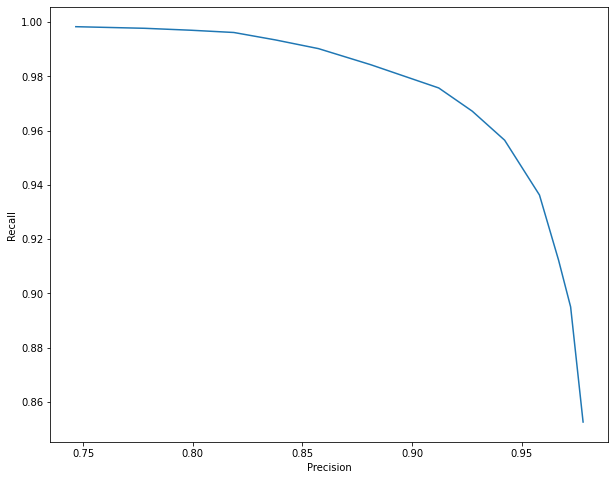

In [386]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(roc['Precision'],roc['Recall'])
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

In [387]:
best_classification = adjust_decision_boundary(results, .97)

# Testing the accuracy for selected dune images

In [391]:
log_name = '../raw_data/logs/testing_combined_classifier_regressor_tfl.csv'

d = {'filename':[],
        'angular_diff':[],
        'speed_diff':[],
    'predicted_angle':[],
    'actual_angle':[],
    'predicted_strength':[],
    'actual_strength':[]}
df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)


In [388]:
dunes = best_classification[best_classification.predicted_class=='dunes'] 

In [392]:
dunes

image actual_class  \
1      ../raw_data/images/testing/dunes/19.2125007629...        dunes   
2      ../raw_data/images/testing/dunes/17.2325004577...        dunes   
4      ../raw_data/images/testing/dunes/22.0674999237...        dunes   
5      ../raw_data/images/testing/dunes/20.5424999237...        dunes   
6      ../raw_data/images/testing/dunes/20.3424991607...        dunes   
...                                                  ...          ...   
16814  ../raw_data/images/testing/dunes/17.6074996948...        dunes   
16817  ../raw_data/images/testing/dunes/26.9625007629...        dunes   
16818  ../raw_data/images/testing/dunes/28.1974990844...        dunes   
16819  ../raw_data/images/testing/dunes/21.8424991607...        dunes   
16821  ../raw_data/images/testing/dunes/21.9174991607...        dunes   

      predicted_class  predicted_proba  
1               dunes         0.994915  
2               dunes         0.983972  
4               dunes         1.000000  
5               dunes         0.999957  
6               dunes         0.999992  
...               ...              ...  
16814           dunes         0.999983  
16817           dunes         0.999744  
16818           dunes         0.970554  
16819           dunes         1.000000  
16821           dunes         1.000000  

[7937 rows x 4 columns]

In [405]:
get_diff(dunes.image.values, path=True)

100%|██████████| 7937/7937 [13:48:54<00:00,  6.27s/it]      


filename  angular_diff  \
0     ../raw_data/images/testing/dunes/19.2125007629...    177.803252   
1     ../raw_data/images/testing/dunes/17.2325004577...     35.396578   
2     ../raw_data/images/testing/dunes/22.0674999237...     45.766115   
3     ../raw_data/images/testing/dunes/20.5424999237...     24.047120   
4     ../raw_data/images/testing/dunes/20.3424991607...      0.003011   
...                                                 ...           ...   
7932  ../raw_data/images/testing/dunes/17.6074996948...      0.971603   
7933  ../raw_data/images/testing/dunes/26.9625007629...    139.931524   
7934  ../raw_data/images/testing/dunes/28.1974990844...     17.697965   
7935  ../raw_data/images/testing/dunes/21.8424991607...     10.201957   
7936  ../raw_data/images/testing/dunes/21.9174991607...    372.984434   

      speed_diff  predicted_angle  actual_angle  predicted_strength  \
0       0.206515       196.065898    182.731609            1.871130   
1       0.001024       187.184818    193.134321            1.815223   
2       0.034988       221.890372    228.655438            1.803707   
3       0.014844       219.288398    214.384612            1.853807   
4       0.018097       213.548236    213.493359            1.820710   
...          ...              ...           ...                 ...   
7932    0.003261       200.453790    199.468090            1.877956   
7933    0.015978       266.844818    278.674084            1.862306   
7934    0.000577       274.731762    270.524867            1.753705   
7935    0.042889       221.302919    218.108869            1.790616   
7936    0.025787       212.125871    231.438676            1.788704   

      actual_strength  
0            2.325569  
1            1.847219  
2            1.990758  
3            1.975643  
4            1.955236  
...               ...  
7932         1.935057  
7933         1.988710  
7934         1.777731  
7935         1.997712  
7936         1.949286  

[7937 rows x 7 columns]

In [406]:
res = pd.read_csv(log_name)
np.sqrt(res.angular_diff.mean())

26.96315473904575

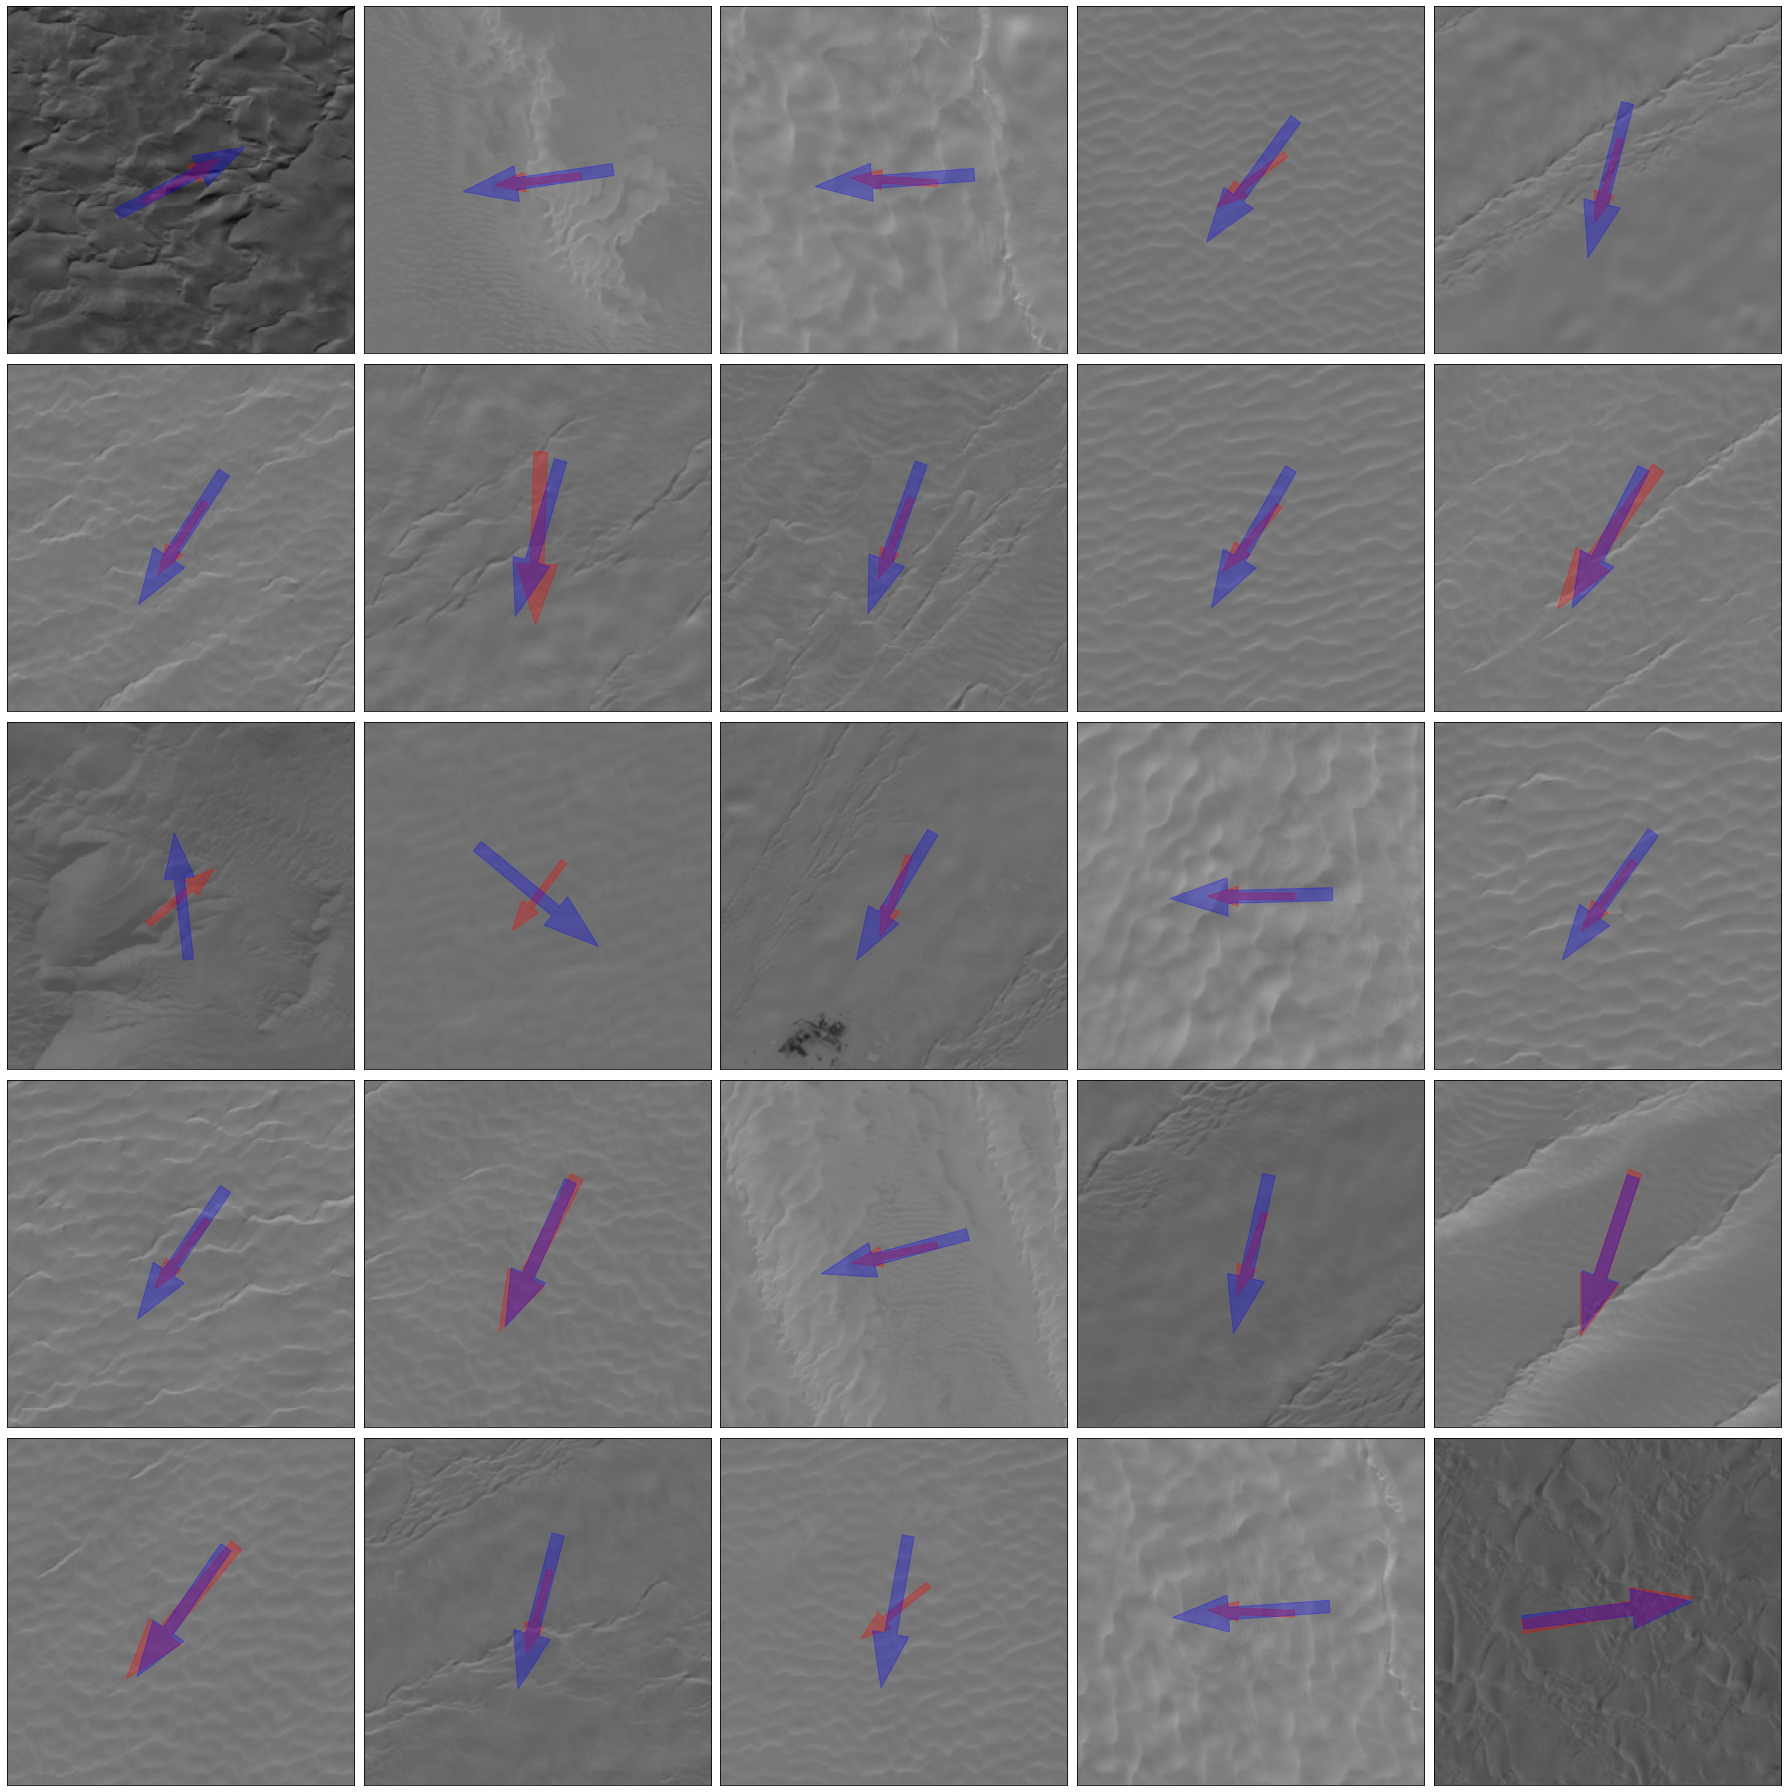

In [422]:
plot_rand_image_grid(image_dim=5,selected_results=res, full_path=True);